In [1]:
import ase,ase.io,ase.io.vasp
import numpy as np
import random
import json
import os, os.path
import matplotlib.pyplot as plt

In [2]:
from onlatt import *

# Использование LRP потенциала в методе Монте-Карло на примере магнитной экиатомной системы VCoNi

### 1. Загрузим готовый потенциал

In [3]:
with open('v_co_ni_lrp.json') as f:
    pot_orig = PotLRP.from_json(f.read())
pot_orig

PotLRP(13 neighbors, V-Co-Ni)

### 2. Восстановим полную "таблицу" потенциала

In [4]:
#convert to full tensor to make calculations fast
pot = pot_orig.to_full_tensor()

### 3. Зададим конфигурацию с которой будет стартовать наша Монте-Карло симуляция

In [5]:
a=3.643
lat = [[a,0.0,0.0],[0.0,a,0.0],[0.0,0.0,a]]
shifts = [[0.0,0.0,0.0],[a/2,a/2,0.0],[a/2,0.0,a/2],[0.0,a/2,a/2]]
shape = [6,6,6]
lat_obj = Lattice(lat, shifts)
cfg = Cfg(lat_obj, shape)

In [6]:
np.random.seed(12345)
types = [PTABLE_ELEMENTS.index(s) for s in ['V','Co','Ni']]
elems = [types[0] for i in range(cfg.n_sites//3)] + \
        [types[1] for i in range((cfg.n_sites+1)//3)] +\
        [types[2] for i in range((cfg.n_sites+1)//3)]
cfg.atomic_numbers = np.random.permutation(elems)

In [7]:
cfg.lattice.neighbors

array([[-1.8215, -1.8215,  0.    ],
       [-1.8215,  0.    , -1.8215],
       [-1.8215,  0.    ,  1.8215],
       [-1.8215,  1.8215,  0.    ],
       [ 0.    , -1.8215, -1.8215],
       [ 0.    , -1.8215,  1.8215],
       [ 0.    ,  0.    ,  0.    ],
       [ 0.    ,  1.8215, -1.8215],
       [ 0.    ,  1.8215,  1.8215],
       [ 1.8215, -1.8215,  0.    ],
       [ 1.8215,  0.    , -1.8215],
       [ 1.8215,  0.    ,  1.8215],
       [ 1.8215,  1.8215,  0.    ]])

### 4. Задаем параметры и тим симуляции СМС = Канонический Монте-Карло, потенциал и стартовую конфигурацию

In [8]:
#creat cmc simulation
CMC_Simulation()
cmc = CMC_Simulation(pot,cfg)
cmc

CMC_Simulation(PotFullTensor(13 neighbors, V-Co-Ni), Cfg(lattice = Lattice(cell = [[3.643, 0.0, 0.0], [0.0, 3.643, 0.0], [0.0, 0.0, 3.643]], shifts = [[0.0, 0.0, 0.0], [1.8215, 1.8215, 0.0], [1.8215, 0.0, 1.8215], [0.0, 1.8215, 1.8215]]), shape = [6, 6, 6]))

In [9]:
cmc.cfg.atomic_numbers

array([27, 27, 27, 27, 23, 27, 23, 27, 27, 23, 28, 27, 28, 23, 23, 27, 28,
       23, 23, 27, 23, 23, 27, 28, 28, 23, 27, 27, 28, 28, 27, 23, 28, 23,
       28, 27, 28, 27, 23, 28, 23, 28, 28, 28, 23, 28, 27, 28, 27, 23, 23,
       28, 28, 27, 23, 28, 23, 27, 28, 23, 27, 27, 28, 27, 27, 23, 28, 23,
       28, 27, 28, 23, 23, 28, 28, 28, 23, 23, 27, 28, 23, 27, 23, 23, 28,
       23, 28, 27, 28, 27, 28, 23, 23, 28, 28, 27, 28, 23, 27, 28, 23, 23,
       27, 23, 27, 23, 28, 23, 28, 28, 28, 28, 27, 23, 27, 27, 28, 23, 23,
       28, 23, 28, 27, 23, 27, 28, 23, 23, 23, 23, 23, 23, 27, 27, 23, 28,
       27, 28, 23, 23, 27, 27, 23, 28, 23, 27, 27, 23, 27, 27, 23, 28, 23,
       27, 27, 23, 28, 27, 28, 23, 23, 28, 23, 27, 28, 23, 23, 28, 27, 23,
       27, 23, 28, 27, 27, 27, 28, 27, 28, 23, 23, 27, 27, 27, 23, 27, 28,
       27, 23, 27, 28, 27, 28, 28, 27, 28, 28, 23, 23, 23, 28, 28, 23, 27,
       27, 27, 27, 28, 28, 23, 23, 23, 23, 27, 27, 27, 27, 28, 28, 28, 28,
       23, 28, 28, 27, 23

In [10]:
cmc.energy() # энергия стартовой конфигурации

-6238.176683232209

### 5. Оценим как быстро проходит расчет

In [11]:
import time
t_start = time.perf_counter()
cmc.Run(n_iter = 1000000, temperature = 100000.0)
print('Million iterations took %f seconds'%(time.perf_counter() - t_start))

Million iterations took 1.384245 seconds


In [12]:
[cmc.accepted_exchanges(),cmc.attempted_exchanges()]

[992637, 1000000]

### 6. Параметр ближнего порядка Воррена-Коули (Warren–Cowley short-range order parameters).
$\alpha_{ij}=1-\frac{p_{ij}}{c_ic_j}$

In [13]:
cmc.sro()

array([[ 0.01001372, -0.00696841, -0.00304531],
       [-0.00696841,  0.00632729,  0.00064112],
       [-0.00304531,  0.00064112,  0.00240419]])

### 7. "Занятость" узлов (site occupancy) кристаллической решетки

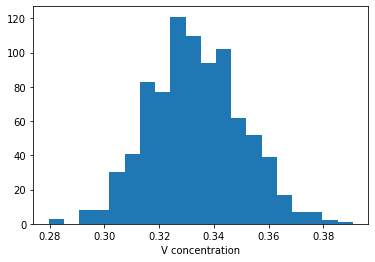

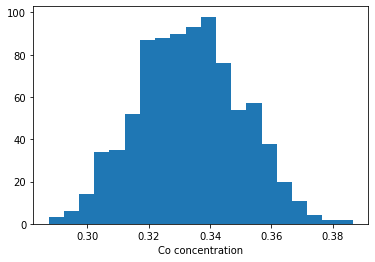

In [14]:
import matplotlib.pyplot as plt
v_occup_prob = cmc.occup_prob()[0] # occupation probability of V
plt.hist(v_occup_prob, bins = 20)
plt.xlabel('V concentration')
plt.show()
co_occup_prob = cmc.occup_prob()[1] # occupation probability of Co
plt.hist(co_occup_prob, bins = 20)
plt.xlabel('Co concentration')
plt.show()

In [15]:
cmc.reset_statistics() # сброс статистики расчетов

### 8. Запустим низкотемпературный расчет и увидим, как система стремится к упорядочению 

In [16]:
cmc.Run(n_iter = 4000000, temperature = 100.0)

In [17]:
[cmc.accepted_exchanges(),cmc.attempted_exchanges()]

[1315780, 4000000]

In [18]:
cmc.sro()

array([[ 0.42861363, -0.2169451 , -0.21166853],
       [-0.2169451 , -0.18111339,  0.39805849],
       [-0.21166853,  0.39805849, -0.18638995]])

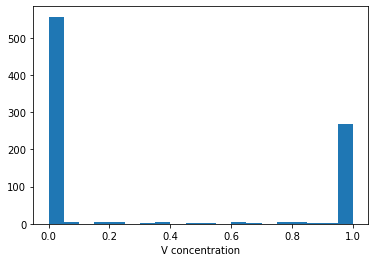

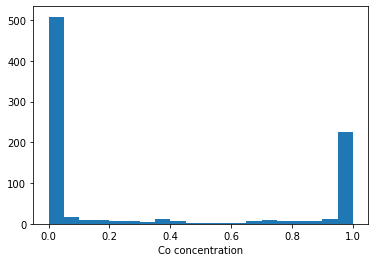

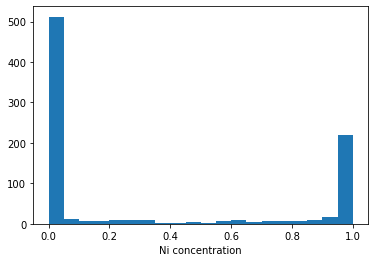

In [19]:
import matplotlib.pyplot as plt
v_occup_prob = cmc.occup_prob()[0] # occupation probability of V
plt.hist(v_occup_prob, bins = 20)
plt.xlabel('V concentration')
plt.show()
co_occup_prob = cmc.occup_prob()[1] # occupation probability of V
plt.hist(co_occup_prob, bins = 20)
plt.xlabel('Co concentration')
plt.show()
ni_occup_prob = cmc.occup_prob()[2] # occupation probability of V
plt.hist(ni_occup_prob, bins = 20)
plt.xlabel('Ni concentration')
plt.show()


In [20]:
cmc.energy()

-6322.035602648212

Стоит отметить, что при создании новой симуляции энергия конфигурации целиком пересчитывается заново, в отличии от расчета энергии в ходе симуляции, где пересчитывается локальный вклад энергии окружения меняющихся атомов

In [21]:
cmc2 = CMC_Simulation(pot,cmc.cfg)
cmc2.energy() - cmc.energy()

-1.4551915228366852e-11

In [22]:
from ase.visualize import view
view(cmc.cfg.to_ase(),viewer='x3d')

In [23]:
cmc = CMC_Simulation(pot,cfg)
cmc.Run(n_iter = 1000000, temperature = 100.0)
cmc.energy_mean()-cmc.energy()

1.5957024813942553

### 9. Проведем большой расчет с понижением температуры для наблюденя фазового перехода порядок-беспорядок, а именно solid solution -> M3V

In [24]:
temp_range = [3400,3000,2800,2600,2400,2200,2000,1800,1700,1600,1500,1450,1400,1350,1300,1200,1000,900,800,700,600]

In [25]:
res = []
sro_vv = []
sro_vco = []
sro_vni = []
en_res = []
cmc = CMC_Simulation(pot,cfg)
for T in temp_range:
    n_it = 4000000
    if T < 1000:
        n_it*=10
    cmc.Run(n_iter = n_it, temperature = T) # отжиг (burn-in, annealing) (чтобы данные всегда соответствовали текущей температуре и не отражали предыдущую)
    cmc.reset_statistics()
    cmc.Run(n_iter = n_it, temperature = T)
    res.append(cmc.energy_var()/( (T * 8.617333262e-5)**2 * cfg.n_sites))
    sro_vv.append(cmc.sro()[0][0])
    sro_vco.append(cmc.sro()[0][1])
    sro_vni.append(cmc.sro()[0][2])
    en_res.append(cmc.energy_mean())

### 10. Рассмотрим зависимость энтальпии от температуры 

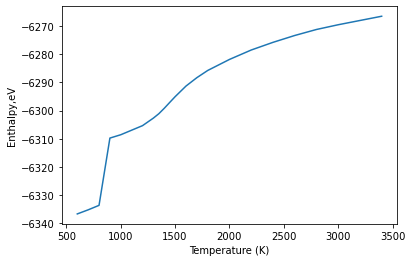

In [26]:
plt.plot(temp_range,en_res)
plt.xlabel('Temperature (K)')
plt.ylabel('Enthalpy,eV');

### 11. Зависимость конфигурационной теплоемкости   $C_V = \frac{\langle E^2\rangle-\langle E\rangle^2}{k_BT}$ 
https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D1%83%D0%BC%D0%BC%D0%B0)

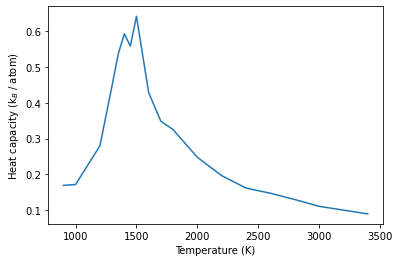

In [27]:
import matplotlib.pyplot as plt
plt.plot(temp_range[:-3],res[:-3])
plt.xlabel('Temperature (K)')
plt.ylabel('Heat capacity (k$_{B}$ / atom)');

### 12. Температурная зависимость параметров ближнего порядка Уорена-Коули (Warren–Cowley short-range order parameters) $\alpha = 1- \frac{p_{ij}}{c_ic_j}$

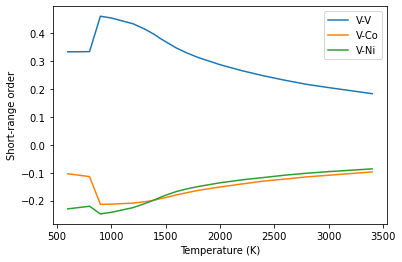

In [28]:
plt.plot(temp_range,sro_vv, label = 'V-V')
plt.plot(temp_range,sro_vco, label = 'V-Co')
plt.plot(temp_range,sro_vni, label = 'V-Ni')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Short-range order');

In [29]:
view(cmc.cfg.to_ase(),viewer='x3d')

# Заготовка для домашнего задания
## В качестве решения домашнего задания вышлите заполненный jupiter notebook с вашей фамилией в названии файла. Ответы на поставленные ниже вопросы оформите в виде комментариев (Markdown, отдельные ячейки) к коду.

## Пример обучения и применения потенциала для системы эквитаомного ОЦК сплава NbMoTaW
### 1. Задаём BCC решетку и ранг разложения tensor train. 

In [3]:
a = 3.239
stencil = np.array([[-1,-1,-1],[-1,-1,1],[-1,1,-1],[-1,1,1],[0,0,0],
                   [1,-1,-1],[1,-1,1],[1,1,-1],[1,1,1]])*a/2
atom_types = ["Nb", "Mo","Ta","W"]
maxrank = 5
pot = PotLRP(stencil, atom_types, maxrank)
rg = PotLRP_Regression(pot)

По-хорошему нужно попробовать несколько maxrank = {3,4,5,6,7} и для каждого провести кросс-валидацию, разбив обучающую выборку хотя бы на 10 частей. Но на кластере на данный момент нельзя запустить параллельное обучение. Поэтому мы обойдемся просто примером обучения одного потенциала, заранее зная, что оптимальным в данном случае является maxrank = 5.

### 2. Ниже происходит считывание обучающей выборки, которая представлена в виде результатов DFT расчетов в программном пакете VASP. OUTCAR файлы расположены в папке NbMoTaW_set и разделены на обучающую и валидационную выборки.

In [4]:
pure_ens=[0.0,0.0,0.0,0.0]#[-8.9873676,-6.5960688,-5.3582289,0.0]
b = a
unit_lattice = Lattice([[b/2.0,b/2.0,b/2.0],
                              [b/2.0,b/2.0,-b/2.0],
                              [-b/2.0,b/2.0,b/2.0]])
stopper = 0
# unit_lattice = Lattice([[b,0.0,0.0],
#                               [0.0,b,0.0],
#                               [0.0,0.0,b]])
for what in ['train','valid']:
    mypath = os.path.join('NbMoTaW_set', what)
    curr_set = []
    dirs = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
    print(dirs)
    for f in dirs:
        mypath2 = os.path.join(mypath,f)
        filename = os.path.join(mypath2)
        print(filename)
        ase_struct = ase.io.vasp.read_vasp_out(filename,0)
        ase_en = ase_struct.get_potential_energy()
        Func = rg.AddTrain if what=='train' else rg.AddValid
        cfg = Cfg.from_ase(unit_lattice, ase_struct)
#         print(cfg)
        stopper = 1
#         if stopper == 1:
#             break
        
        conc=[np.bincount(cfg.atomic_numbers)[41],np.bincount(cfg.atomic_numbers)[42],np.bincount(cfg.atomic_numbers)[73],np.bincount(cfg.atomic_numbers)[74]]
        Func(cfg, ase_en + (conc[0]*pure_ens[0]+conc[1]*pure_ens[1]+conc[2]*pure_ens[2]+conc[3]*pure_ens[3]))

['OUTCAR_23', 'OUTCAR_2', 'OUTCAR_46', 'OUTCAR_0', 'OUTCAR_51', 'OUTCAR_7', 'OUTCAR_25', 'OUTCAR_5', 'OUTCAR_10', 'OUTCAR_49', 'OUTCAR_26', 'OUTCAR_24', 'OUTCAR_17', 'OUTCAR_44', 'OUTCAR_54', 'OUTCAR_3', 'OUTCAR_13', 'OUTCAR_1', 'OUTCAR_11', 'OUTCAR_4', 'OUTCAR_42', 'OUTCAR_45', 'OUTCAR_12', 'OUTCAR_21', 'OUTCAR_48', 'OUTCAR_22', 'OUTCAR_57', 'OUTCAR_56', 'OUTCAR_14', 'OUTCAR_16', 'OUTCAR_39', 'OUTCAR_6', 'OUTCAR_53', 'OUTCAR_15', 'OUTCAR_20', 'OUTCAR_40', 'OUTCAR_55', 'OUTCAR_50', 'OUTCAR_41', 'OUTCAR_19', 'OUTCAR_43', 'OUTCAR_47']
NbMoTaW_set/train/OUTCAR_23
NbMoTaW_set/train/OUTCAR_2
NbMoTaW_set/train/OUTCAR_46
NbMoTaW_set/train/OUTCAR_0
NbMoTaW_set/train/OUTCAR_51
NbMoTaW_set/train/OUTCAR_7
NbMoTaW_set/train/OUTCAR_25
NbMoTaW_set/train/OUTCAR_5
NbMoTaW_set/train/OUTCAR_10
NbMoTaW_set/train/OUTCAR_49
NbMoTaW_set/train/OUTCAR_26
NbMoTaW_set/train/OUTCAR_24
NbMoTaW_set/train/OUTCAR_17
NbMoTaW_set/train/OUTCAR_44
NbMoTaW_set/train/OUTCAR_54
NbMoTaW_set/train/OUTCAR_3
NbMoTaW_set/train/

Обычно для 4ёх-компонентной системы необходимо порядка 200-300 атомных конфигураций, но в данном наборе представлены только отобранные в ходе моделирования методом Монте-Карло, репрезентативные конфигурации, поэтому хватило порядка 50 конфигураций. 

In [32]:
rg

PotLRP_Regression(PotLRP(9 neighbors, Nb-Mo-Ta-W), 42 train terms, 7 valid terms)

### 3. Ниже сохраняем данные для обучения. Переходим в терминал и для запуска обучения запускаем команду "sbatch -N 1 -n 1 run_train.sh". В силу того, что параллельный запуск на кластере сейчас не возможен, то обучение длится порядка 45 минут. Идем пить чай ;)

In [33]:
with open('nb_mo_ta_w_train_task.json','w') as f:
    f.write(rg.to_json())

In [34]:
{"train error":np.sqrt(rg.TrainLoss()), "valid error": np.sqrt(rg.ValidLoss())}

{'train error': 11.514614144351192, 'valid error': 11.525995778598034}

### 4. Загрузим наш обученный в пункте 3 потенциал (проверьте, что потенциал успешно обучился в фале slurm-*номер_задачи*.out)
Конец должен выглядеть примерно так:"train error: 0.000184579
valid error: 0.0013636"

In [5]:
with open('NbMoTaW_trained.json') as f:
    pot_orig = PotLRP.from_json(f.read())
pot_orig

PotLRP(9 neighbors, Nb-Mo-Ta-W)

In [6]:
#convert to full tensor to make calculations fast
pot = pot_orig.to_full_tensor()

### 5. Далее, как было в примере, показанном на семинаре для VCoNi, пожалуйста проведите исследование фазового перехода порядок-беспорядок для экиатомного ОЦК сплава NbMoTaW. Выполните задания и ответьте на следующие вопросы:
1) Попробуйте различные размеры моделируемой системы. Как меняются результаты исследования в зависимости от числа атомов в системе?

2) Не забывайте, что чем больше атомов, тем большо шагов Монте-Карло необходимо системе для достижения соответствующего распределения. Чем ниже температура, тем меньше шагов "принимается", для низких температур следует также увеличивать число шагов.

3) Определите при каких температурах проиходит фазовый переход (переходы?). В соответствующем интервале, следует уменьшить шаг по температуре.

4) Каким структурам соответствует переход (переходы?), какой порядок наблюдается (как называются такие структуры)?

5) При каждом расчете проверяйте, что энтальпия при низких (при высоких) температурах выходит на горизонталь, а значит система достигает равновесия (основного состояния). 

Ответы также можно найти в статье https://www.nature.com/articles/s41524-019-0195-y

In [130]:
# shape = [6,6,6]
# lat_obj = unit_lattice
# cfg = Cfg(lat_obj, shape)

In [131]:
# np.random.seed(12345)
# types = [PTABLE_ELEMENTS.index(s) for s in atom_types]
# elems = [types[0] for i in range(cfg.n_sites//3)] + \
#         [types[1] for i in range((cfg.n_sites+1)//3)] +\
#         [types[2] for i in range((cfg.n_sites+1)//3)]
# cfg.atomic_numbers = np.random.permutation(elems)

In [132]:
#create cmc simulation
# CMC_Simulation()
# cmc = CMC_Simulation(pot,cfg)
# cmc

In [133]:
# print(f'Энергия стартовой конфигурации при shape={shape}:', cmc.energy())

In [134]:
# import time
# t_start = time.perf_counter()
# cmc.Run(n_iter = 1000000, temperature = 100000.0)
# print('Million iterations took %f seconds'%(time.perf_counter() - t_start))

In [135]:
# [cmc.accepted_exchanges(),cmc.attempted_exchanges()]

Проверено различие энергий стартовой конфигурации для разных размеров (shape) и времен расчетов:
- (6, 6, 6): -2480.3998018806637 & 0.813183 seconds
- (9, 9, 9): -8368.481162379772 & 0.834208 seconds
- (12, 12, 12): -19839.39879029697 & 0.859254 seconds

In [136]:
# cmc.Run(n_iter = 4000000, temperature = 100.0)

In [137]:
# [cmc.accepted_exchanges(),cmc.attempted_exchanges()]

In [138]:
# cmc.sro()

In [139]:
# import matplotlib.pyplot as plt
# # NbMoTaW
# nb_occup_prob = cmc.occup_prob()[0] # occupation probability of V
# plt.hist(nb_occup_prob, bins = 20)
# plt.xlabel('Nb concentration')
# plt.show()
# mo_occup_prob = cmc.occup_prob()[1] # occupation probability of V
# plt.hist(mo_occup_prob, bins = 20)
# plt.xlabel('Mo concentration')
# plt.show()
# ta_occup_prob = cmc.occup_prob()[2] # occupation probability of V
# plt.hist(ta_occup_prob, bins = 20)
# plt.xlabel('Ta concentration')
# plt.show()
# w_occup_prob = cmc.occup_prob()[2] # occupation probability of V
# plt.hist(w_occup_prob, bins = 20)
# plt.xlabel('W concentration')
# plt.show()

In [140]:
# cmc.energy()

In [141]:
# from ase.visualize import view
# view(cmc.cfg.to_ase(),viewer='x3d')

In [142]:
# temp_range = [2000,1800,1600,
#               1400,1200,
#               1000,900,800,700,650,600,550,
#               500, 400, 350, 300, 250, 200, 100]

In [144]:
# res = []
# sro_nbnb = []
# sro_nbmo = []
# sro_nbta = []
# sro_nbw = []
# en_res = []
# cmc = CMC_Simulation(pot,cfg)
# # NbMoTaW
# for T in temp_range:
#     n_it = 4000000
#     if T < 1000:
#         n_it*=10
#     cmc.Run(n_iter = n_it, temperature = T) # отжиг (burn-in, annealing) (чтобы данные всегда соответствовали текущей температуре и не отражали предыдущую)
#     cmc.reset_statistics()
#     cmc.Run(n_iter = n_it, temperature = T)
#     res.append(cmc.energy_var()/( (T * 8.617333262e-5)**2 * cfg.n_sites))
#     sro_nbnb.append(cmc.sro()[0][0])
#     sro_nbmo.append(cmc.sro()[0][1])
#     sro_nbta.append(cmc.sro()[0][2])
#     sro_nbw.append(cmc.sro()[0][3])
#     en_res.append(cmc.energy_mean())

In [145]:
# print(f'При shape={shape}')
# plt.plot(temp_range,en_res)
# plt.xlabel('Temperature (K)')
# plt.ylabel('Enthalpy,eV');

In [146]:
# print(f'При shape={shape}')
# plt.plot(temp_range,res)
# plt.xlabel('Temperature (K)')
# plt.ylabel('Heat capacity (k$_{B}$ / atom)');

In [147]:
# print(f'При shape={shape}')
# plt.plot(temp_range,sro_nbnb, label = 'Nb-Nb')
# plt.plot(temp_range,sro_nbmo, label = 'Nb-Mo')
# plt.plot(temp_range,sro_nbta, label = 'Nb-Ta')
# plt.plot(temp_range,sro_nbw, label = 'Nb-W')
# plt.legend()
# plt.xlabel('Temperature (K)')
# plt.ylabel('Short-range order');

Энергия стартовой конфигурации при shape=[4, 4, 4]: -736.5976296490669
При shape=[4, 4, 4]


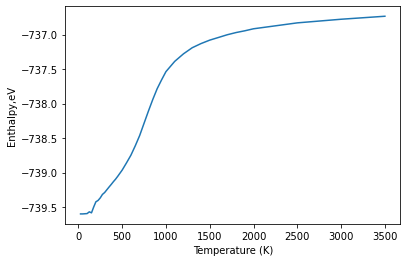

При shape=[4, 4, 4]


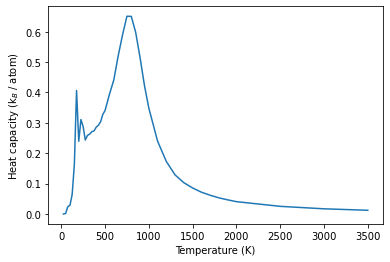

При shape=[4, 4, 4]


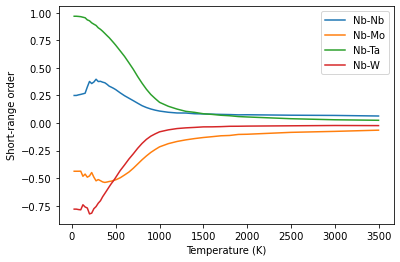

Энергия стартовой конфигурации при shape=[6, 6, 6]: -2485.4254920978487
При shape=[6, 6, 6]


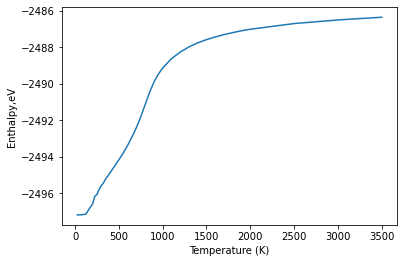

При shape=[6, 6, 6]


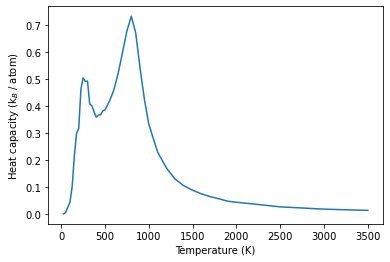

При shape=[6, 6, 6]


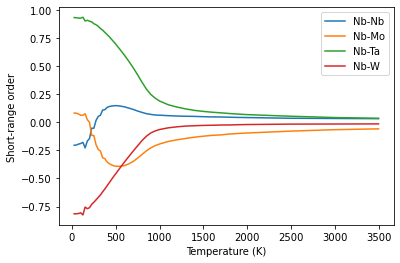

Энергия стартовой конфигурации при shape=[8, 8, 8]: -5894.0288728726
При shape=[8, 8, 8]


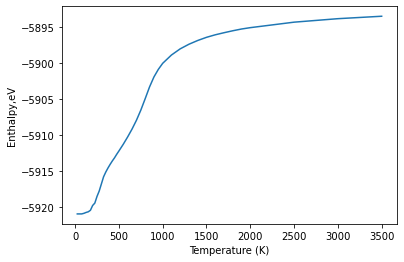

При shape=[8, 8, 8]


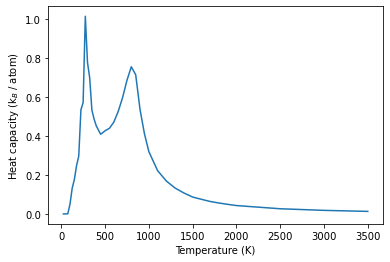

При shape=[8, 8, 8]


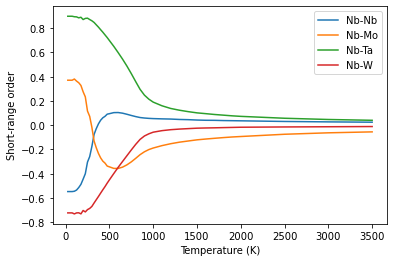

In [23]:
shapes = [
    [4, 4, 4],
    [6, 6, 6],
    [8, 8, 8]
]

ns_it = [
    1000000,
    4000000,
    8000000
]

for shape_, n_it_ in zip(shapes, ns_it):
    shape = shape_
    lat_obj = unit_lattice
    cfg = Cfg(lat_obj, shape)
    
    np.random.seed(12345)
    types = [PTABLE_ELEMENTS.index(s) for s in atom_types]
    elems = [types[0] for i in range(cfg.n_sites//4)] + \
            [types[1] for i in range((cfg.n_sites+1)//4)] +\
            [types[2] for i in range((cfg.n_sites+1)//4)] +\
            [types[3] for i in range((cfg.n_sites+1)//4)]
    cfg.atomic_numbers = np.random.permutation(elems)
    
    CMC_Simulation()
    cmc = CMC_Simulation(pot,cfg)
    
    print(f'Энергия стартовой конфигурации при shape={shape}:', cmc.energy())
    
    temp_range = list(range(3500, 2000, -500))\
                + list(range(2000, 1000, -100))\
                + list(range(1000, 500, -50))\
                + list(range(500, 0, -25))
    
    res = []
    sro_nbnb = []
    sro_nbmo = []
    sro_nbta = []
    sro_nbw = []
    en_res = []
    cmc = CMC_Simulation(pot,cfg)
    # NbMoTaW
    for T in temp_range:
        n_it = n_it_
        if T < 1000:
            n_it*=10
        cmc.Run(n_iter = n_it, temperature = T) # отжиг (burn-in, annealing) (чтобы данные всегда соответствовали текущей температуре и не отражали предыдущую)
        cmc.reset_statistics()
        cmc.Run(n_iter = n_it, temperature = T)
        res.append(cmc.energy_var()/( (T * 8.617333262e-5)**2 * cfg.n_sites))
        sro_nbnb.append(cmc.sro()[0][0])
        sro_nbmo.append(cmc.sro()[0][1])
        sro_nbta.append(cmc.sro()[0][2])
        sro_nbw.append(cmc.sro()[0][3])
        en_res.append(cmc.energy_mean())
        
    print(f'При shape={shape}')
    plt.plot(temp_range,en_res)
    plt.xlabel('Temperature (K)')
    plt.ylabel('Enthalpy,eV')
    plt.show()
    
    print(f'При shape={shape}')
    plt.plot(temp_range,res)
    plt.xlabel('Temperature (K)')
    plt.ylabel('Heat capacity (k$_{B}$ / atom)')
    plt.show()
    
    print(f'При shape={shape}')
    plt.plot(temp_range,sro_nbnb, label = 'Nb-Nb')
    plt.plot(temp_range,sro_nbmo, label = 'Nb-Mo')
    plt.plot(temp_range,sro_nbta, label = 'Nb-Ta')
    plt.plot(temp_range,sro_nbw, label = 'Nb-W')
    plt.legend()
    plt.xlabel('Temperature (K)')
    plt.ylabel('Short-range order')
    plt.show()
    

Все 3 запуска показывают, что есть фазовые переходы в районе 300К и 800К, что подтверждается в статье. Энтальпия в расчетах начинает заворачивать в горизонталь.

Начиная с ~800К система приходит к фазе твердого раствора, до этого проходит через некоторые упорядоченные фазы.

Увеличение структуры приводит к улучшению статистической точности метода, но требует значительно большего времени расчетов.

In [25]:
from ase.visualize import view

## Вид структуры без релаксации

In [37]:
shape = [4,4,16]
# unit_lattice = Lattice([[b/2.0,b/2.0,b/2.0],
#                         [b/2.0,b/2.0,-b/2.0],
#                         [-b/2.0,b/2.0,b/2.0]])
lat = [[a,0.0,0.0],[0.0,a,0.0],[0.0,0.0,a]]
shifts = [[0.0,0.0,0.0],[a/2,a/2,a/2]]
unit_lattice = Lattice(lat, shifts)
lat_obj = unit_lattice
cfg = Cfg(lat_obj, shape)

np.random.seed(12345)
types = [PTABLE_ELEMENTS.index(s) for s in atom_types]
elems = [types[0] for i in range(cfg.n_sites//4)] + \
        [types[1] for i in range((cfg.n_sites+1)//4)] +\
        [types[2] for i in range((cfg.n_sites+1)//4)] +\
        [types[3] for i in range((cfg.n_sites+1)//4)]
cfg.atomic_numbers = np.random.permutation(elems)

cmc = CMC_Simulation(pot,cfg)
view(cmc.cfg.to_ase(),viewer='x3d')

## Релаксация структуры при 100 К

In [41]:
shape = [4,4,16]
lat_obj = unit_lattice
cfg = Cfg(lat_obj, shape)

np.random.seed(12345)
types = [PTABLE_ELEMENTS.index(s) for s in atom_types]
elems = [types[0] for i in range(cfg.n_sites//4)] + \
        [types[1] for i in range((cfg.n_sites+1)//4)] +\
        [types[2] for i in range((cfg.n_sites+1)//4)] +\
        [types[3] for i in range((cfg.n_sites+1)//4)]
cfg.atomic_numbers = np.random.permutation(elems)

cmc = CMC_Simulation(pot,cfg)
n_it = 100000000
T = 100
cmc.Run(n_iter = n_it, temperature = T) # отжиг (burn-in, annealing) (чтобы данные всегда соответствовали текущей температуре и не отражали предыдущую)
cmc.reset_statistics()
cmc.Run(n_iter = n_it, temperature = T)

view(cmc.cfg.to_ase(), viewer='x3d')

## Релаксация структуры при 2000 К

In [42]:
shape = [4,4,16]
lat_obj = unit_lattice
cfg = Cfg(lat_obj, shape)

np.random.seed(12345)
types = [PTABLE_ELEMENTS.index(s) for s in atom_types]
elems = [types[0] for i in range(cfg.n_sites//4)] + \
        [types[1] for i in range((cfg.n_sites+1)//4)] +\
        [types[2] for i in range((cfg.n_sites+1)//4)] +\
        [types[3] for i in range((cfg.n_sites+1)//4)]
cfg.atomic_numbers = np.random.permutation(elems)

cmc = CMC_Simulation(pot,cfg)
n_it = 10000000
T = 2000
cmc.Run(n_iter = n_it, temperature = T) # отжиг (burn-in, annealing) (чтобы данные всегда соответствовали текущей температуре и не отражали предыдущую)
cmc.reset_statistics()
cmc.Run(n_iter = n_it, temperature = T)

view(cmc.cfg.to_ase(),viewer='x3d')